# Research Skills: Spatiotemporal Data Analyis
## Take-home Assignment
Sharon Ong, Department of Cognitive Science and Artificial Intelligence, 
Tilburg University
Academic Year 2022-2023

Your First Name: Christophe

Your Last Name: Friezas Gonçalves

Your Student ID: 2059012

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm

from sklearn.model_selection import GridSearchCV

from sktime.utils.plotting import plot_correlations
from sktime.utils.plotting import plot_series

from sktime.transformations.series.detrend import STLTransformer

from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_evaluation import evaluate

from sktime.split import temporal_train_test_split,SlidingWindowSplitter

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from sktime.regression.distance_based import KNeighborsTimeSeriesRegressor

# Part 1A
## Time-Series Analysis of Energy Consumption in the Netherlands.

1. [3 points] Load the dataset. Find the earliest date and the most recent date of your dataset. 

Points breakdown: 1 point for loading the dataset, 1 point for the earliest date and 1 point for the latest date.

In [5]:
#
# Your code goes here 
#
data =pd.read_csv(join('data', '2059012_time.csv'), header=0, index_col=0, parse_dates=True)
print(data.head())

#We exclude the time information for better visualisation
data = data.asfreq("M")


#Given that the data is ordered we can take the first and the last entry in the dataframe for earliest and most recent
earliest = data.iloc[0].name
recent = data.iloc[-1].name
print(f"The earliest date: {earliest} and the most recent date: {recent}")

            Consumption
1986-01-01         5774
1986-02-01         5246
1986-03-01         5422
1986-04-01         5272
1986-05-01         5008
The earliest date: 1986-01 and the most recent date: 2020-02


2. [5 points] Display the temporal autocorelation and partial autocorrelation in a plot. From the plot, motivate why the periodicity is 12 months.

Points breakdown: 3 points for displaying the autocorrelations. 2 points for motivation.

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

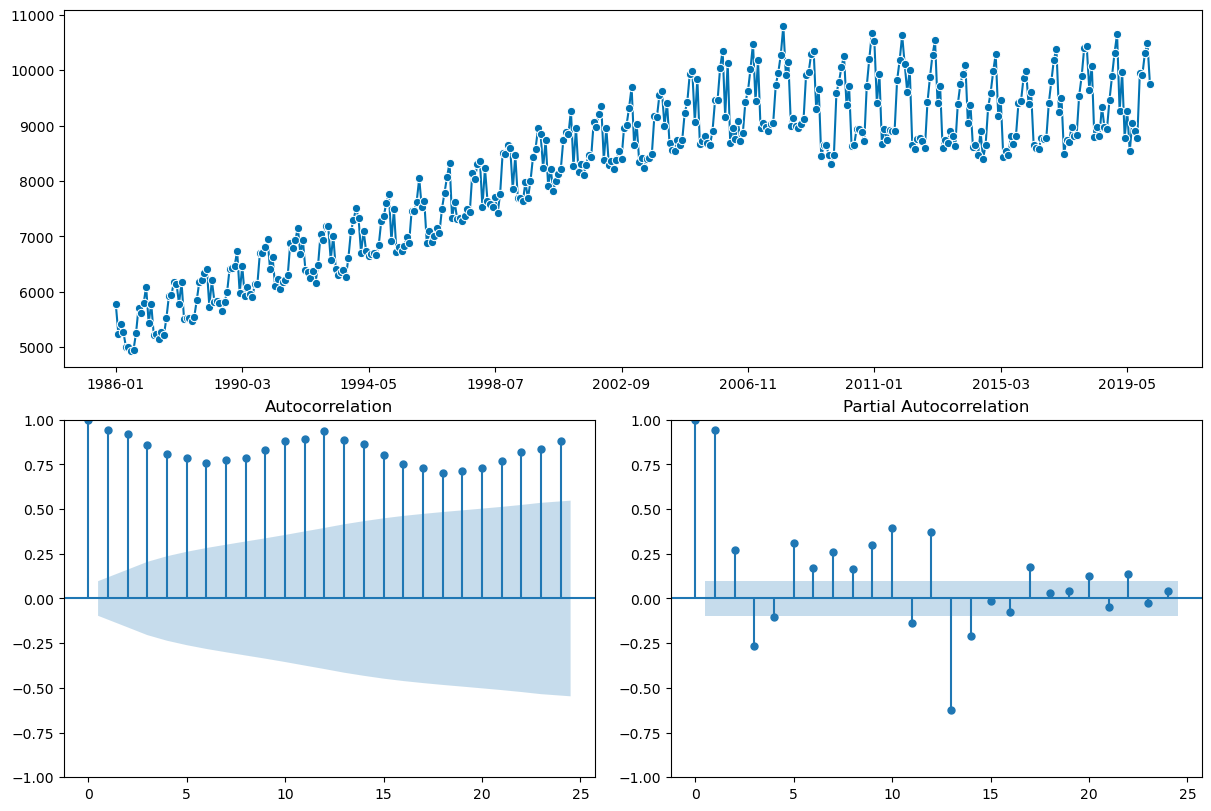

In [7]:
#
# Your code goes here 
#

#Motivation after the plots
plot_correlations(data)

In [8]:
#In the graph we can observe that there is a periodic behaviour that repeats itself in a 12 month cycle. 
#The trend is overall increasing in our graph but these recurring peaks are periodic over a 12 month cycle.

4. [10 points] Separate the trend, seasonal and residual noise components. Display each component separately. Display the residual noise as a scatter plot. From your interpretation of the residual plots, are there are cyclic, trend or seasonal effects which are unaccounted for?
Points breakdown: 3 points for separating the trend, 2 points for displaying each component. 3 points for the scatter plot, histogram plot of the residuals and 2 points for your intepreration.

(array([  2.,   8.,  22.,  75., 121.,  94.,  63.,  21.,   3.,   1.]),
 array([-295.04885868, -234.30576155, -173.56266443, -112.8195673 ,
         -52.07647017,    8.66662696,   69.40972408,  130.15282121,
         190.89591834,  251.63901547,  312.38211259]),
 <BarContainer object of 10 artists>)

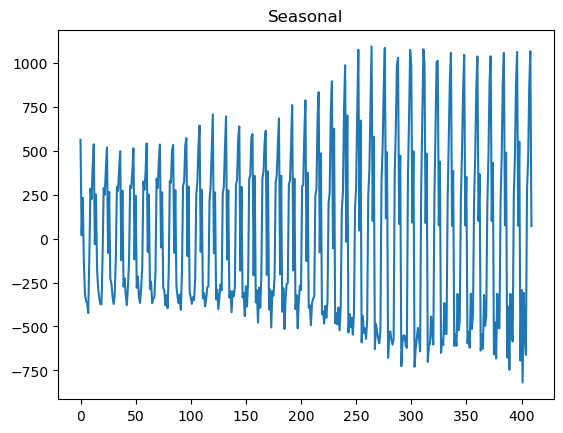

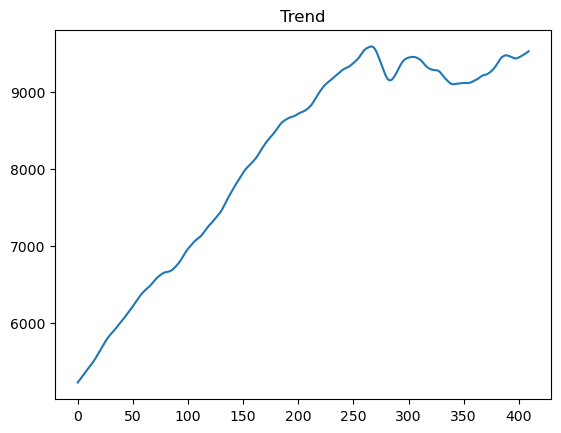

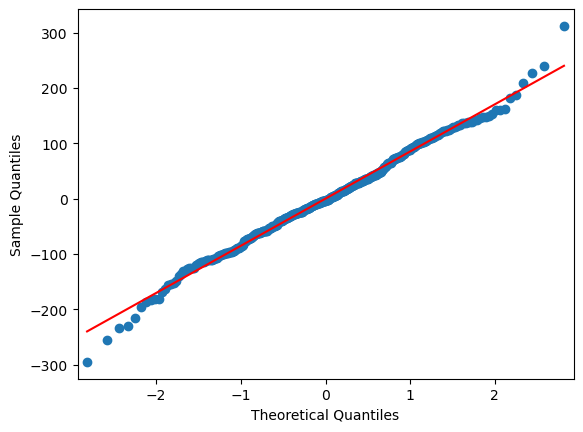

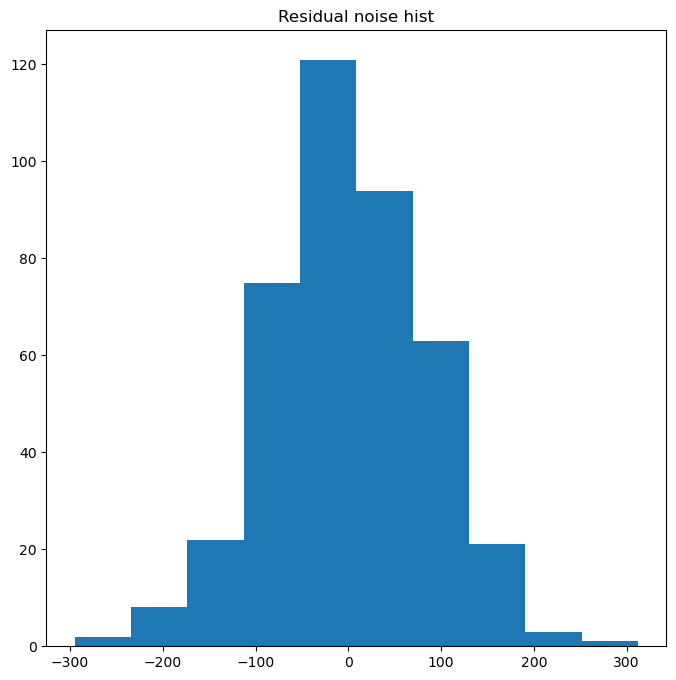

In [10]:
#
# Your code goes here 
#

transformer = STLTransformer(sp=12, return_components=True)

result =  transformer.fit_transform(data)
plt.figure()
plt.title("Seasonal")
plt.plot(result.seasonal.values)

plt.figure()
plt.title("Trend")
plt.plot(result.trend.values)


_ = sm.qqplot(result.resid, line='r')

plt.figure(figsize=(8,8))
plt.title("Residual noise hist")
plt.hist(result.resid)

In [11]:
# The seasonal plot shows a cyclic pattern depicting the fluctuation over a 12 month cycle as previously stated.
# The cyclic pattern, its periodicity, stays the same, only chaning in amplitude. 
# We have a positive trend in our data which smooths out around the 250-300 mark of the plot.  
# The residual plot shows a normal distribution in the scatter plot as well being backed up by the histogram. 

4. [4 points]  This question is on time series forecasting with ARIMA
* Split the time series into a train, validation and test set. Set the forecasting horizon of the validation set to be 60 months and the test set to 60 months (2 points)
* Fit an ARIMA or SARIMA model on the training set. Find the optimal p,d and q values for ARIMA (by evaluating the mean absolute percentage error on the validation set). Chose at least 3 different values for p and 2 different values for d and q. (6 points)
* With the best p,d and q values you found, fit an ARIMA model on the combined train and validation set. Evaluate your model on the test set by computing the mean absolute percentage error.(6 points)
* Display the train, validation, test set and your predicted solution Label your plot. (1 point)

ARIMA(4, 0, 0) RMSE=0.129
ARIMA(4, 0, 1) RMSE=0.115
ARIMA(4, 0, 2) RMSE=0.065
ARIMA(4, 0, 3) RMSE=0.063
ARIMA(8, 0, 1) RMSE=0.052
ARIMA(8, 1, 1) RMSE=0.050
ARIMA(12, 0, 2) RMSE=0.044
ARIMA(12, 0, 3) RMSE=0.040
ARIMA(16, 1, 0) RMSE=0.038
Best ARIMA(16, 1, 0) RMSE=0.038
Mean absolute percentage error with best configuration on test set: 0.02318914405040594


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

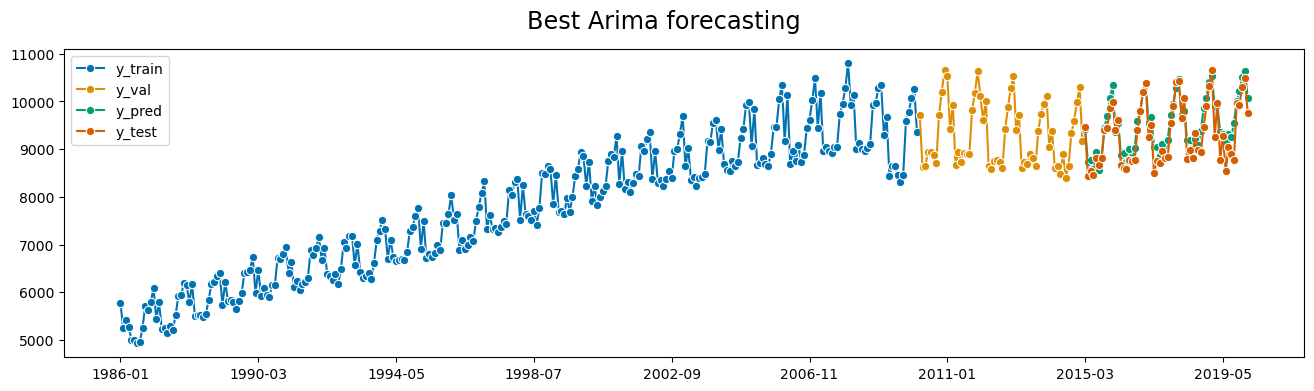

In [25]:
#
# Your code goes here 
#

data = data.asfreq('M')
y_train, y_test = temporal_train_test_split(data, test_size=60)
y_train, y_val = temporal_train_test_split(y_train, test_size=60)

fh = np.arange(1, 61)

p_values = [4, 8, 12, 16]
d_values = range(0, 2)
q_values = range(0, 4)
best_score, best_cfg = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            arima_order=(p,d,q)
            forecaster = ARIMA(order=arima_order,suppress_warnings=True)
            forecaster.fit(y_train)
            y_pred = forecaster.predict(fh=fh)

            rmape = mean_absolute_percentage_error(y_val, y_pred)
            if rmape < best_score:
                best_score, best_cfg = rmape, arima_order
                print('ARIMA%s RMSE=%.3f' % (arima_order,rmape))

print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

y_train2 = pd.concat([y_train,y_val])

arima_order=best_cfg
forecaster = ARIMA(order=arima_order, suppress_warnings=True)
forecaster.fit(y_train2)
y_pred = forecaster.predict(fh=fh)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean absolute percentage error with best configuration on test set: " + str(mape))

plot_series(y_train, y_val , y_pred, y_test ,labels=["y_train","y_val", "y_pred", "y_test"], title = 'Best Arima forecasting')

5. (7 points) This question is on time series regression with K-Nearest Neighbour using the sklearn or sktime package.
* Split the time series into a train and test set. Set of the test set to 60 month. Using `GridSearchCV`, train a KNN regessor with a 5-fold cross validation. Find the best regularization (nearest neighbour) hyperparameter with 5 different neighbour values. (3 points)
* Using the best hyperparameter found from grid search on the training set, evaluate the mean absolute percentage error on the test set. (When you call grid search.fit, the best hyperparameter is automatically found and stored in grid search). (3 points)
* Display the train, validation, test set and your predicted solution. Label your plot. (1 point)

CV on n_neighbors: 1
   test_MeanAbsolutePercentageError  fit_time  pred_time  len_train_window  \
0                          0.026586  0.234003   3.657793               250   
1                          0.027084  0.178522   2.740029               250   
2                          0.052762  0.183311   2.709304               250   
3                          0.028921  0.183229   3.068256               250   
4                          0.027853  0.204695   2.677421               250   

    cutoff  
0  2006-10  
1  2007-08  
2  2008-06  
3  2009-04  
4  2010-02  

CV on n_neighbors: 2
   test_MeanAbsolutePercentageError  fit_time  pred_time  len_train_window  \
0                          0.025846  0.182754   2.764659               250   
1                          0.026891  0.189652   2.736615               250   
2                          0.063831  0.177620   2.723013               250   
3                          0.039325  0.208064   2.714001               250   
4                   

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

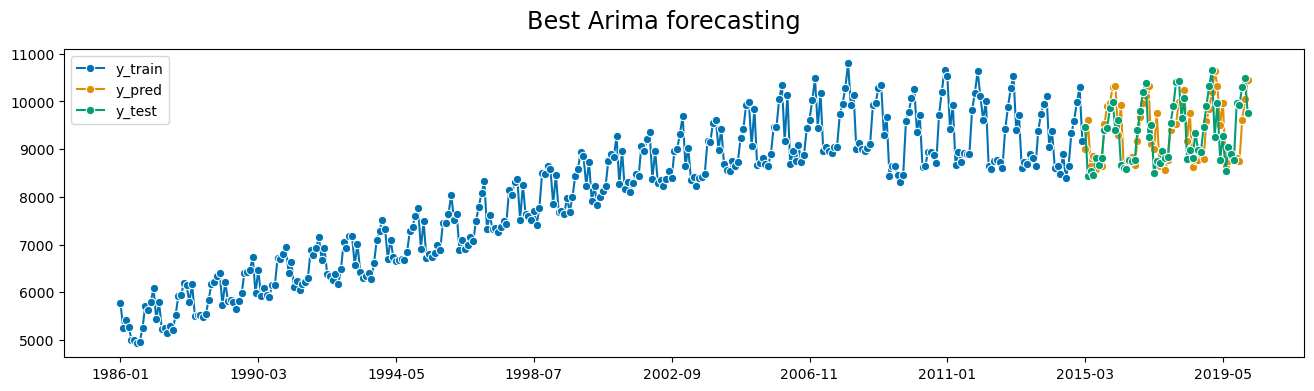

In [29]:
#
# Your code goes here 
#
from sklearn.neighbors import KNeighborsRegressor


d = data.copy()
d = d.dropna()


y_train, y_test = temporal_train_test_split(d, test_size=60)


#After long testing to get GridSearchCV to work with the sliding window, I was not able to do so.
#Thus I created a manual implementation to work with the sliding window function and implementing cross validation
#Aquiring the best parameter for KNN

best_param = (300,0)

for i,n in enumerate(np.arange(1, 10)):
    print("CV on n_neighbors: "+str(n))
    regressor = KNeighborsTimeSeriesRegressor(n)
    forecaster = make_reduction(regressor, strategy="recursive")
    cv = SlidingWindowSplitter(fh=fh, window_length=250, step_length=10)
    out = evaluate(forecaster,cv,y=y_train)
    
    if out["test_MeanAbsolutePercentageError"].min() < best_param[0]:
        best_param = (out["test_MeanAbsolutePercentageError"].min(),n)
    print(out)
    print()

    
print("Best Solution :" + str(best_param))

regressor = KNeighborsTimeSeriesRegressor(best_param[1])
forecaster = make_reduction(regressor, strategy="recursive")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean absolute percentage error with best configuration on test set: " + str(mape))

plot_series(y_train , y_pred, y_test ,labels=["y_train", "y_pred", "y_test"], title = 'Best Arima forecasting')